In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
CURR_DIR = os.path.dirname('__file__')
ROOT_DIR=os.path.join(os.getcwd() ,'..')
sys.path.append(ROOT_DIR)

from omegaconf import OmegaConf
#load configs
config = OmegaConf.load(os.path.join(ROOT_DIR,'run_scripts/configs/ddpm/exp01_T1_brain_config.yaml'))

In [2]:
from src.utils.initialize_configs import instantiate_from_configs
ddpmModel = instantiate_from_configs(config.model)
datasetName = 'T1_BRAIN'

/home/akshay/miniconda3/envs/synthrad/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/akshay/.local/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [3]:
%%capture
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import TQDMProgressBar, Timer, ModelCheckpoint
import time

# stop training after 12 hours
timer = Timer(duration="00:12:00:00")

# or provide a datetime.timedelta
from datetime import timedelta
timer = Timer(duration=timedelta(weeks=1))
timestr = time.strftime("%d%m%y-%H%M%S")
loss_type = ddpmModel.loss_type
alpha = ddpmModel.learning_rate
checkpoint = ModelCheckpoint(
    save_top_k=2,
    monitor="val/loss_simple",    
    filename=timestr + "-{epoch}-{step}-" + "-loss=%s"%loss_type + "-a=%.1E"%alpha + '-' + datasetName
)
# trainer = Trainer(max_steps=ddpmModel.max_tsteps, accelerator="gpu", devices=-1, callbacks=[TQDMProgressBar(refresh_rate=10), timer, checkpoint], gradient_clip_val=1., gradient_clip_algorithm="value") # To use all available GPUs put -1 or '-1'
trainer = Trainer(max_steps=ddpmModel.max_tsteps, callbacks=[TQDMProgressBar(refresh_rate=10), timer, checkpoint], gradient_clip_val=1., gradient_clip_algorithm="value") # To use all available GPUs put -1 or '-1'


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
for batch in ddpmModel.train_dataloader():
    print(batch)
    break

In [12]:
image = batch['x_prior']

In [21]:
len(image_1)

16

In [20]:
image_1[..., None].shape

torch.Size([16, 1, 284, 284, 1])

In [18]:
image.shape

torch.Size([16, 284, 284])

In [16]:
image_1 = image.unsqueeze(1)

In [22]:
image_1.shape

torch.Size([16, 1, 284, 284])

In [23]:
import torch
cimage = torch.concat((image_1, image_1), dim=1)

In [24]:
cimage.shape

torch.Size([16, 2, 284, 284])

In [4]:
trainer.fit(ddpmModel)

# query training/validation/test time (in seconds)
print("Total training time: %.2f mins" % (timer.time_elapsed("train")/60))


  | Name  | Type             | Params
-------------------------------------------
0 | model | DiffusionWrapper | 9.3 M 
-------------------------------------------
9.3 M     Trainable params
0         Non-trainable params
9.3 M     Total params
37.125    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 2, 3, 3], expected input[1, 1, 568, 284] to have 2 channels, but got 1 channels instead

In [9]:
ddpmModel.cond_train_split

In [6]:
for batch in ddpmModel.train_dataloader():
    print(batch)
    break

In [11]:
import torch
data_dir = "/home/akshay/Documents/cse_sem_6/synthrad2023/algorithm-template/data/Task1"  # Specify the directory containing the patient folders
brain_dataset = SimpleITKDataset(data_dir, anatomy="brain")
# pelvis_dataset = SimpleITKDataset(data_dir, anatomy="pelvis")

num_samples = len(brain_dataset)
batch_size = 4  # Specify the desired batch size
num_batches = num_samples // batch_size # Specify the desired batch size
# brain_dataloader = torch.utils.data.DataLoader(brain_dataset, batch_size=batch_size, shuffle=True)
# pelvis_dataloader = torch.utils.data.DataLoader(pelvis_dataset, batch_size=batch_size, shuffle=True)


brain_train_loader, brain_val_loader, brain_test_loader = split_dataset(brain_dataset, batch_size=num_batches, tvt_ratio=[0.6,0.2,0.2])
# pelvis_train_loader, pelvis_val_loader, pelvis_test_loader = split_dataset(pelvis_dataset, batch_size=batch_size, tvt_ratio=[0.6,0.2,0.2])


In [9]:
len(brain_dataset[3]['x_cond'])

167

In [12]:
for batch in brain_val_loader:
    print(batch)

In [8]:
batch

NameError: name 'batch' is not defined

In [5]:
bimages = brain_dataset[0]['x_prior']
pimages = pelvis_dataset[0]['x_prior']

In [28]:
padded_bimages = brain_dataset.pad_images(bimages)
padded_pimages = pelvis_dataset.pad_images(pimages)

In [29]:
len(padded_pimages)

110

In [ ]:
for s in range(len(padded_pimages)):
    print(padded_pimages[s].shape)

In [6]:
bimages[0].shape

(284, 284)

In [25]:
bimages.shape

(207, 240, 175)

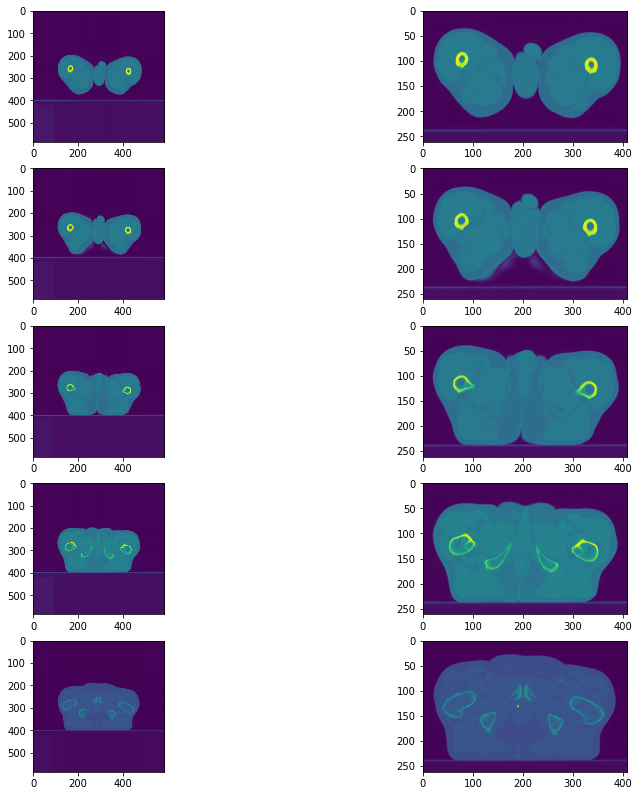

In [30]:
rows=5
freq = 10
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(14,14))
for i in range(len(pimages) // freq):
        if i < rows:
            img_dim0 = padded_pimages[i*freq] #[i*freq]
            img_dim1 = pimages[i*freq] #[i*freq]
            # img_dim1 = padded_bimages[:,i*10,:]
            # img_dim2 = padded_bimages[:,:,i*10]
            axes[i, 0].imshow(img_dim0)      
            axes[i, 1].imshow(img_dim1) 
            # axes[i, 2].imshow(img_dim2)

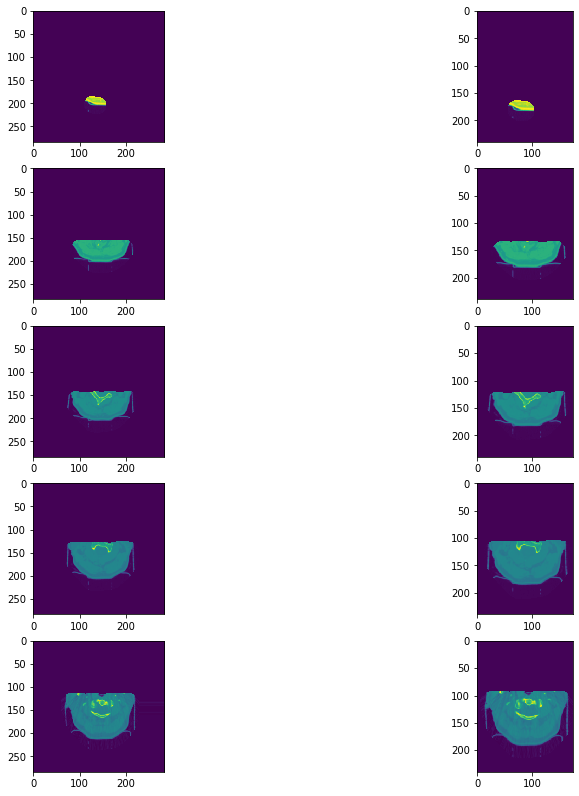

In [31]:
rows=5
freq = 10
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(14,14))
for i in range(len(bimages) // freq):
        if i < rows:
            img_dim0 = padded_bimages[i*freq] #[i*freq]
            img_dim1 = bimages[i*freq] #[i*freq]
            # img_dim1 = padded_bimages[:,i*10,:]
            # img_dim2 = padded_bimages[:,:,i*10]
            axes[i, 0].imshow(img_dim0)      
            axes[i, 1].imshow(img_dim1) 
            # axes[i, 2].imshow(img_dim2) 

In [ ]:
for batch in brain_train_loader:
    print(batch.shape)
    break

In [8]:
len(brain_train_loader.dataset)


108

In [4]:
pelvis_dataset[0]['ct'].shape

(110, 262, 408)

In [5]:
brain_dataset[0]['mr'].shape

(207, 240, 175)

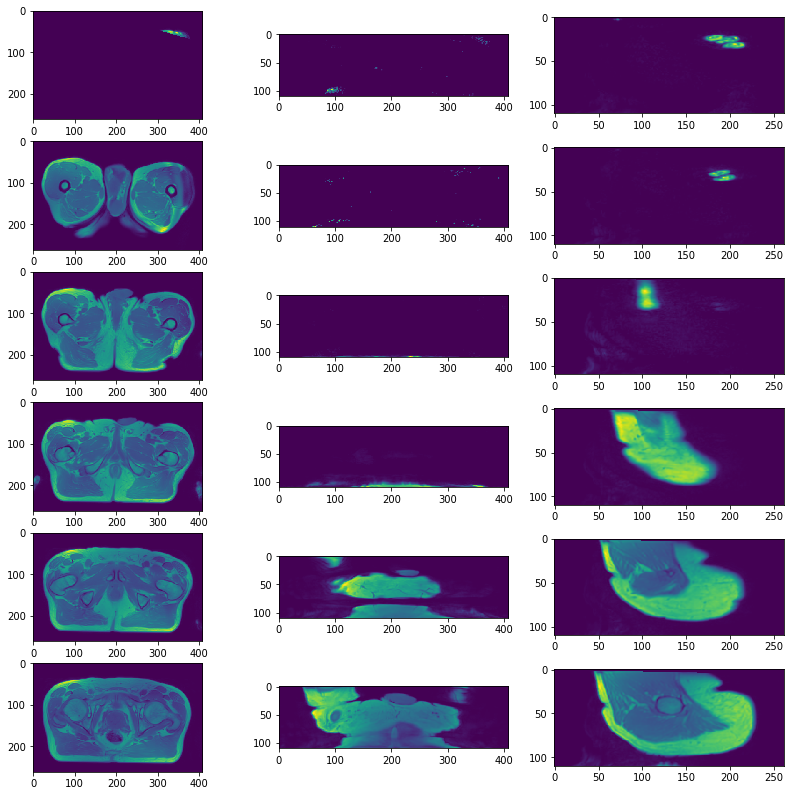

In [5]:

show_images(pelvis_dataset, vis_sample_num=0, scan_type='mr', num_slices=6, freq=10) #[0]['mr']) 

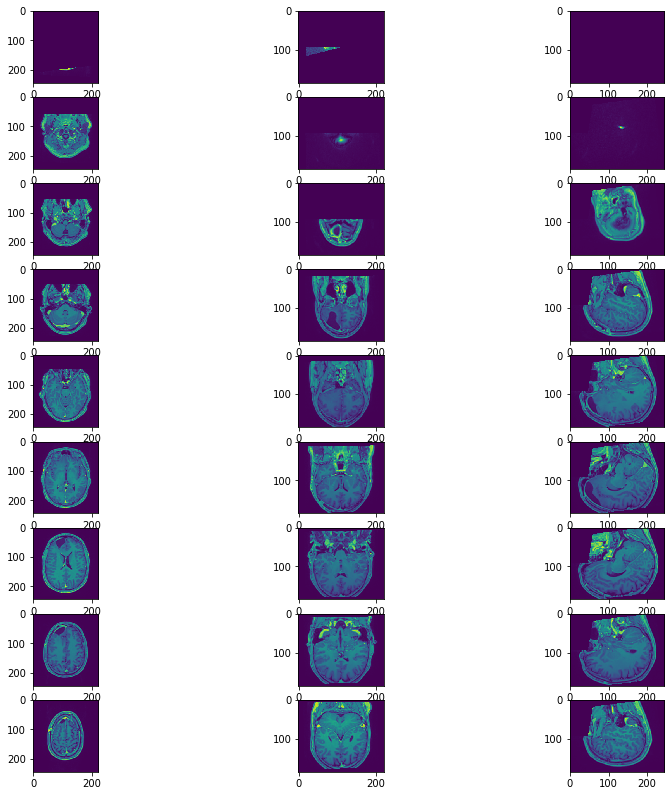

In [10]:
# visualizing (vis_sample_num)th images
show_images(brain_dataset, vis_sample_num=5, scan_type='mr', num_slices=9, freq=20) #[0]['mr']) 

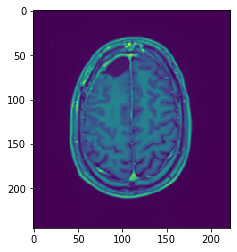

In [15]:
plt.imshow(brain_dataset[5]['mr'][150])

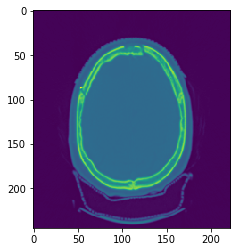

In [16]:
plt.imshow(brain_dataset[5]['ct'][150])

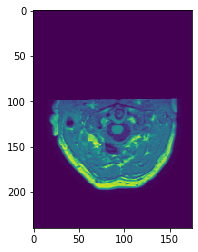

In [8]:
plt.imshow(brain_dataset[0]['mr'][50])